# 라이브러리

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import seaborn as sns
from pylab import rcParams
from collections import Counter
import tensorflow as tf
from tensorflow.keras import Model ,models, layers, optimizers, regularizers

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 준비

In [3]:
raw_data = pd.read_csv('/content/drive/MyDrive/번천/dataset/train_data.csv')
raw_test = pd.read_csv('/content/drive/MyDrive/번천/dataset/test_data.csv')

In [4]:
raw_data.head()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0


In [5]:
raw_data['type'].value_counts()

0    432
1    369
2    366
3    306
4    306
5    249
6    249
7    186
Name: type, dtype: int64

In [6]:
raw_test['type'].value_counts()

0    1296
1    1107
2    1098
3     918
4     918
5     747
6     747
7     558
Name: type, dtype: int64

In [7]:
## 공기압축기가 돌아가는 순서로 열 새롭게 구성

train_data = raw_data[['air_inflow', 'motor_rpm', 'motor_current', 'motor_vibe', 'motor_temp',  'out_pressure', 'air_end_temp', 'type']].copy()
test_data = raw_test[['air_inflow', 'motor_rpm', 'motor_current', 'motor_vibe', 'motor_temp',  'out_pressure', 'air_end_temp', 'type']].copy()

설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)

설비 번호 1: 20HP

설비 번호 2: 10HP

설비 번호 3: 50HP

In [8]:
hp30 = [0, 4, 5, 6, 7]
hp20 = [1]
hp10 = [2]
hp50 = [3]

In [9]:
# 설비별 데이터 세트 분리

train_data_30hp = train_data[train_data['type'].isin(hp30)].copy()
train_data_20hp = train_data[train_data['type'].isin(hp20)].copy()
train_data_10hp = train_data[train_data['type'].isin(hp10)].copy()
train_data_50hp = train_data[train_data['type'].isin(hp50)].copy()

In [10]:
# 설비별 데이터 세트 분리

test_data_30hp = test_data[test_data['type'].isin(hp30)].copy()
test_data_20hp = test_data[test_data['type'].isin(hp20)].copy()
test_data_10hp = test_data[test_data['type'].isin(hp10)].copy()
test_data_50hp = test_data[test_data['type'].isin(hp50)].copy()

# 모델 생성과 함수 설정

In [11]:
# # define the autoencoder network model
# def autoencoder_model(X):
#     inputs = Input(shape=(X.shape[1], X.shape[2]))
#     L1 = LSTM(16, activation='relu', return_sequences=True, 
#               kernel_regularizer=regularizers.l2(0.00))(inputs)
#     L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
#     L3 = RepeatVector(X.shape[1])(L2)
#     L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
#     L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
#     output = TimeDistributed(Dense(X.shape[2]))(L5)    
#     model = Model(inputs=inputs, outputs=output)
#     return model

In [12]:
# 모델 구조
timesteps = 7
n_features = 1
layer_1 = 64
layer_2 = 32

# seed 고정
seed = 123

In [13]:
class lstm_ae(tf.keras.Model):
  def __init__(self, timesteps, n_features, layer_1, layer_2):
    super(lstm_ae).__init__()
    self.n_features = n_features
    self.timesteps = timesteps
    self.layer_1 = layer_1
    self.layer_2 = layer_2


  def encoder(self, x):
    x = layers.LSTM(self.layer_1, activation = 'relu', return_sequences = True)(x)
    x = layers.LSTM(self.layer_2, activation = 'relu', return_sequences = False)(x)
    en_output = layers.RepeatVector(self.timesteps)(x)
    return en_output

  def decoder(self, x):
    x = layers.LSTM(self.layer_2, activation = 'relu', return_sequences = True)(x)
    x = layers.LSTM(self.layer_1, activation = 'relu', return_sequences = True)(x)
    de_output = layers.TimeDistributed(layers.Dense(self.n_features))(x)

    return de_output

  def build(self):
    inputs = Input(shape = (self.timesteps, self.n_features))
    encoder = self.encoder(inputs)
    decoder = self.decoder(encoder)

    return Model(inputs, decoder)

In [14]:
# lstm 구조에 맞게 데이터 변형하는 함수

def slicing(X, lookback):
    output_X = []
    # output_y = []
    for i in range(len(X) - lookback +1):
        t = []
        for j in range(0, lookback):
            t.append(X[(i + j), :])
        output_X.append(t)
    return np.array(output_X)

In [15]:
## 평행 좌표 그리는 함수

def parallel(for_view, num):
  parallel_coordinates(frame = for_view[for_view['type'].isin(num)], class_column = 'type', colormap = plt.get_cmap('Set1'));

In [16]:
## 모델 평가를 위해 3차원을 2차원으로 줄임

def flatten(X):
    flattened_X = X.reshape(X.shape[0], -1)
    return flattened_X

In [17]:
## timestep 3 이기 때문에 처음 두 개의 데이터에 대한 가정

def plus(anom):
  if anom[0] == 0:
    return [0,0] + list(anom*1)
  else:
    return [0,1] + list(anom*1)

# 경로 설정

In [18]:
# 현재 폴더 경로 지정
PATH = '/content/drive/MyDrive/번천/모델 10'
os.chdir(PATH)
os.getcwd()

'/content/drive/MyDrive/번천/모델 10'

# hp30

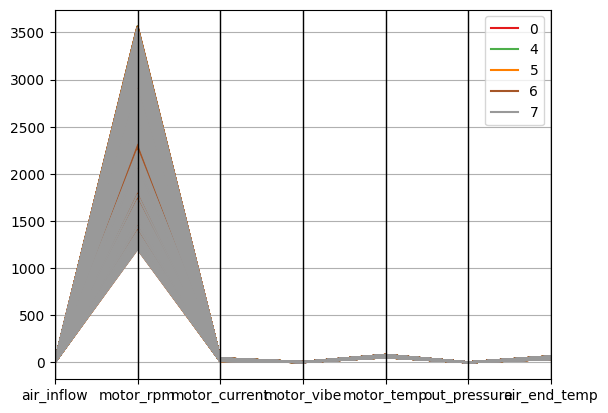

In [ ]:
parallel(train_data, hp30)

## 첫 번째 모델

In [20]:
## 모델 학습을 위해 데이터 준비

scaler_30hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화


full_data = pd.concat([test_data, train_data], ignore_index = True)
scaler_30hp.fit(full_data.drop(['type'], axis=1))
test_scale_30hp = scaler_30hp.transform(test_data_30hp.drop(['type'], axis=1))
train_scale_30hp = scaler_30hp.transform(train_data_30hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_30hp = slicing(test_scale_30hp,1).reshape(-1, 7 ,1)
train_slice_30hp = slicing(train_scale_30hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_30hp, test_size=0.1, random_state=seed)

In [21]:
## 모델 학습

lstm_ae_30hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_30hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장/30hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_30hp.fit(X_train, X_train,
                           epochs=300, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./30hp_history.npy',history.history)

Epoch 1/300
40/40 [==============================] - ETA: 0s - loss: 0.1910
Epoch 1: val_loss improved from inf to 0.09261, saving model to ./모델 저장/30hp.h5
40/40 [==============================] - 9s 61ms/step - loss: 0.1910 - val_loss: 0.0926 - lr: 0.0010
Epoch 2/300
39/40 [============================>.] - ETA: 0s - loss: 0.0874
Epoch 2: val_loss improved from 0.09261 to 0.08290, saving model to ./모델 저장/30hp.h5
40/40 [==============================] - 2s 40ms/step - loss: 0.0872 - val_loss: 0.0829 - lr: 0.0010
Epoch 3/300
38/40 [===========================>..] - ETA: 0s - loss: 0.0804
Epoch 3: val_loss improved from 0.08290 to 0.07724, saving model to ./모델 저장/30hp.h5
40/40 [==============================] - 1s 35ms/step - loss: 0.0801 - val_loss: 0.0772 - lr: 0.0010
Epoch 4/300
39/40 [============================>.] - ETA: 0s - loss: 0.0756
Epoch 4: val_loss improved from 0.07724 to 0.07090, saving model to ./모델 저장/30hp.h5
40/40 [==============================

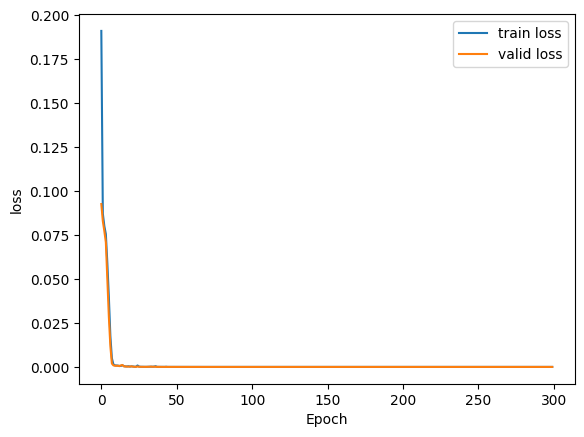

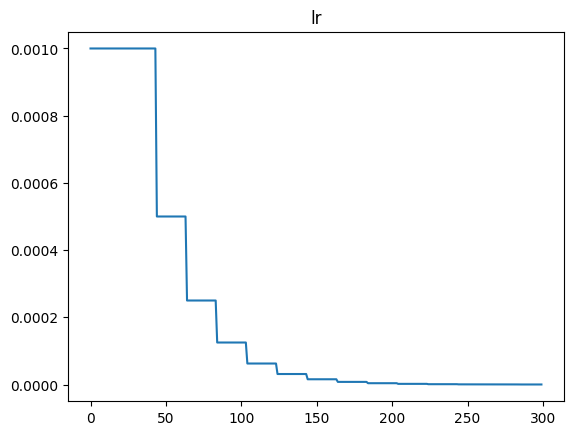

In [22]:
# 저장한 model과 history 불러오기
lstm_ae_30hp = load_model('./모델 저장/30hp.h5')
history = history=np.load('./30hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [23]:
# 역치 계산
pred_train_30hp = lstm_ae_30hp.predict(train_slice_30hp)
train_mse_30hp = np.mean(np.square(flatten(train_slice_30hp) - flatten(pred_train_30hp)), axis =1 )
threshold_30hp = np.max(train_mse_30hp)

# 계산한 역치로 이상 판단
pred_test_30hp = lstm_ae_30hp.predict(test_slice_30hp)
test_mse_30hp = np.mean(np.square(flatten(test_slice_30hp) - flatten(pred_test_30hp)), axis =1 )
anom_30hp = test_mse_30hp > threshold_30hp

# pred 데이터 생성
pred_30hp = test_data_30hp.copy()
pred_30hp['y'] = anom_30hp

# 개수 확인
print(np.sum(anom_30hp))

134/134 [==============================] - 1s 7ms/step
293


In [ ]:
# plt.figure(figsize = (15,5));
# plt.plot(np.sort(test_mse_30hp)[-291:])
# plt.ylim(0,0.003)

# anom_30hp = test_mse_30hp > np.sort(test_mse_30hp)[-291]

# # pred 데이터 생성
# pred_30hp = test_data_30hp.copy()
# pred_30hp['y'] = anom_30hp

# # 개수 확인
# print(np.sum(anom_30hp))

290


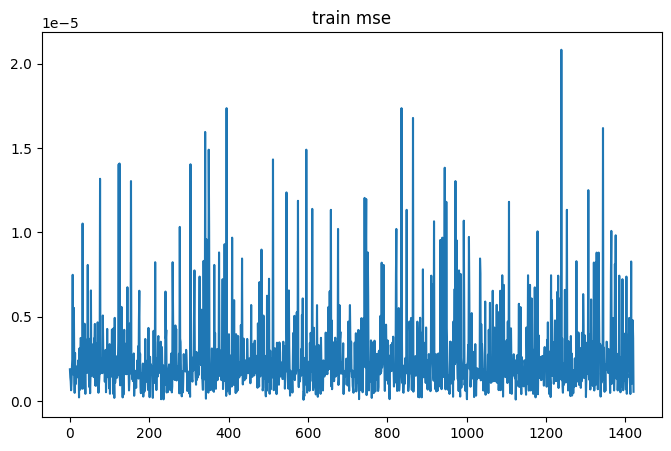

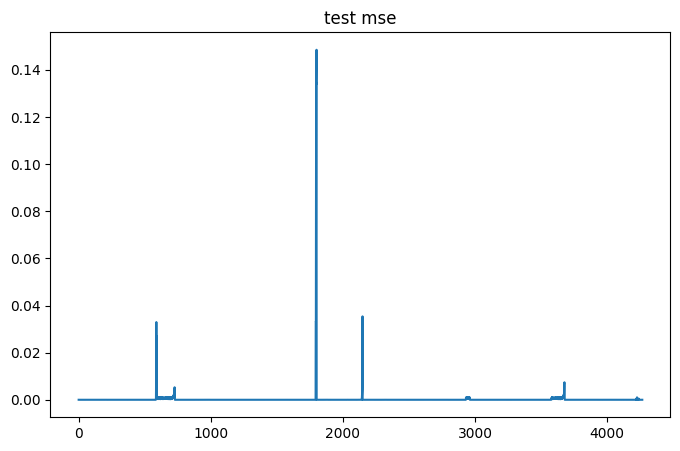

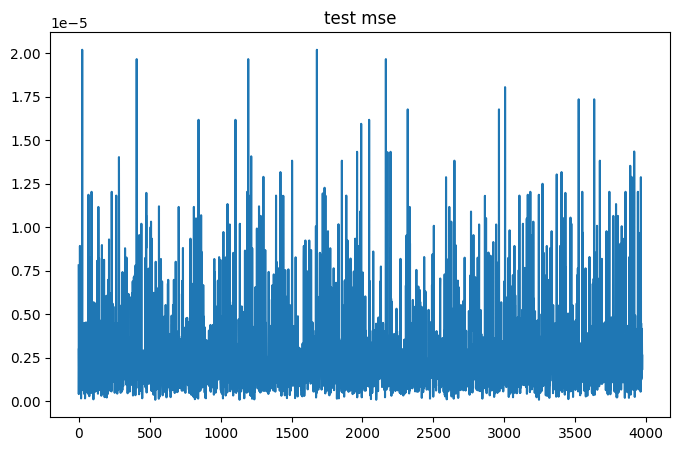

In [24]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_30hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_30hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_30hp[~anom_30hp]);
plt.title('test mse');

## 두 번째 모델

In [ ]:
## test mse가 train mse의 평균 + 1 표준편차보다 작은 데이터들 학습에 사용

for_new_train_30hp = test_data_30hp[test_mse_30hp < (np.mean(train_mse_30hp) + np.std(train_mse_30hp))].copy()
new_train_30hp = pd.concat([train_data_30hp, for_new_train_30hp], ignore_index = True) 

In [ ]:
new_train_30hp.to_csv('/content/drive/MyDrive/번천/모델 9/new_train/new_train_30hp.csv')

In [ ]:
## 모델 학습을 위해 데이터 준비

scaler_30hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_30hp = pd.concat([test_data_30hp, train_data_30hp], ignore_index = True)
scaler_30hp.fit(full_data_30hp.drop(['type'], axis=1))
train_scale_30hp = scaler_30hp.transform(new_train_30hp.drop(['type'], axis=1))
test_scale_30hp = scaler_30hp.transform(test_data_30hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_30hp = slicing(test_scale_30hp,1).reshape(-1, 7 ,1)
train_slice_30hp = slicing(train_scale_30hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_30hp, test_size=0.1, random_state=seed)

In [ ]:
## 모델 학습

lstm_ae_30hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_30hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장2/30hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_30hp.fit(X_train, X_train,
                           epochs=300, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./history2/30hp_history.npy',history.history)

Epoch 1/300
135/135 [==============================] - ETA: 0s - loss: 0.1276
Epoch 1: val_loss improved from inf to 0.05148, saving model to ./모델 저장2/30hp.h5
135/135 [==============================] - 11s 27ms/step - loss: 0.1276 - val_loss: 0.0515 - lr: 0.0010
Epoch 2/300
134/135 [============================>.] - ETA: 0s - loss: 0.0411
Epoch 2: val_loss improved from 0.05148 to 0.03871, saving model to ./모델 저장2/30hp.h5
135/135 [==============================] - 3s 22ms/step - loss: 0.0410 - val_loss: 0.0387 - lr: 0.0010
Epoch 3/300
135/135 [==============================] - ETA: 0s - loss: 0.0198
Epoch 3: val_loss improved from 0.03871 to 0.00060, saving model to ./모델 저장2/30hp.h5
135/135 [==============================] - 3s 24ms/step - loss: 0.0198 - val_loss: 6.0092e-04 - lr: 0.0010
Epoch 4/300
133/135 [============================>.] - ETA: 0s - loss: 2.0157e-04
Epoch 4: val_loss improved from 0.00060 to 0.00006, saving model to ./모델 저장2/30hp.h5
135/135 [=

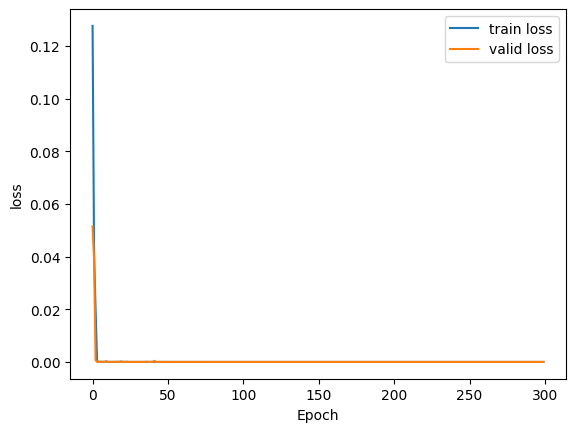

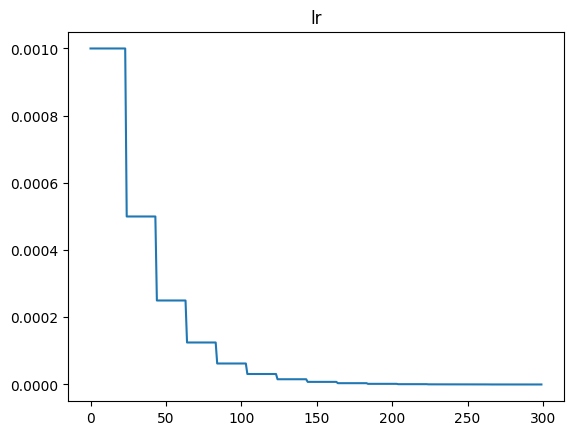

In [ ]:
# 저장한 model과 history 불러오기
lstm_ae_30hp = load_model('./모델 저장2/30hp.h5')
history = history=np.load('./history2/30hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [ ]:
# 역치 계산
pred_train_30hp = lstm_ae_30hp.predict(train_slice_30hp)
train_mse_30hp = np.mean(np.square(flatten(train_slice_30hp) - flatten(pred_train_30hp)), axis =1 )
threshold_30hp = np.max(train_mse_30hp)

# 계산한 역치로 이상 판단
pred_test_30hp = lstm_ae_30hp.predict(test_slice_30hp)
test_mse_30hp = np.mean(np.square(flatten(test_slice_30hp) - flatten(pred_test_30hp)), axis =1 )
anom_30hp = test_mse_30hp > threshold_30hp

# pred 데이터 생성
pred_30hp = test_data_30hp.copy()
pred_30hp['y'] = anom_30hp

# 개수 확인
print(np.sum(anom_30hp))

134/134 [==============================] - 1s 7ms/step
291


In [ ]:
anom_30hp = test_mse_30hp > np.mean(train_mse_30hp) + 10*np.std(train_mse_30hp)

# pred 데이터 생성
pred_30hp = test_data_30hp.copy()
pred_30hp['y'] = anom_30hp

# 개수 확인
print(np.sum(anom_30hp))

325


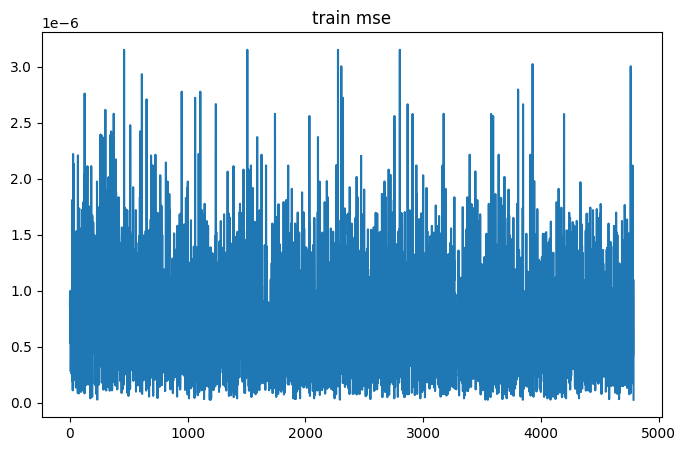

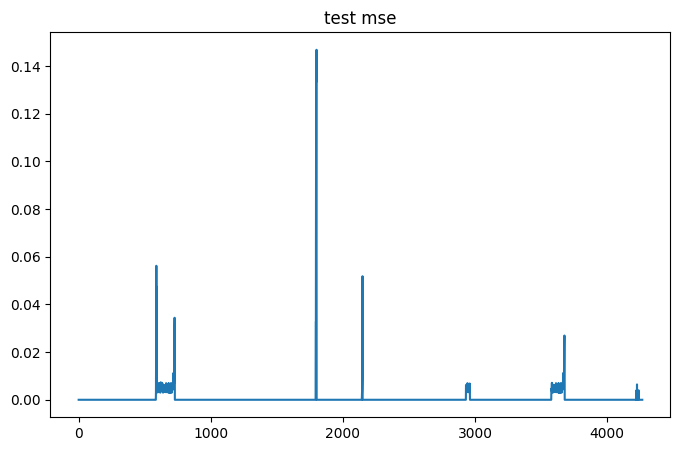

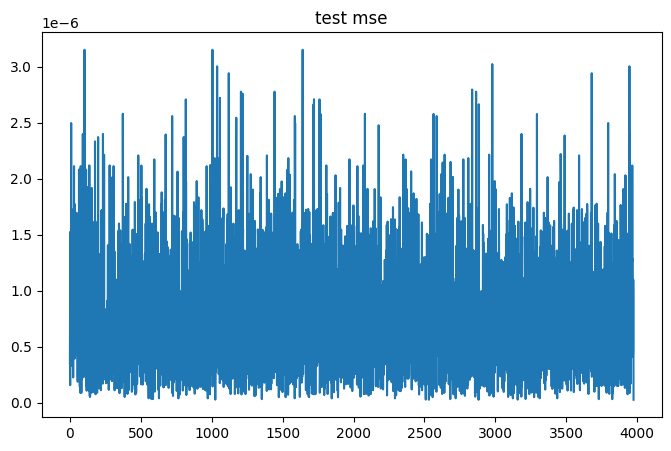

In [ ]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_30hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_30hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_30hp[~anom_30hp]);
plt.title('test mse');

# hp20

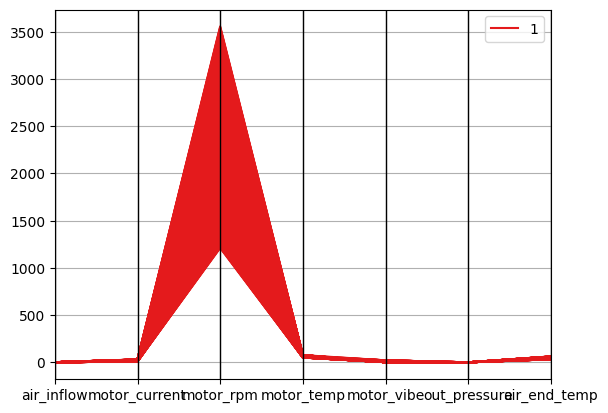

In [ ]:
parallel(train_data, hp20)

## 첫 번째 모델

In [25]:
## 모델 학습을 위해 데이터 준비

scaler_20hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화


full_data = pd.concat([test_data, train_data], ignore_index = True)
scaler_20hp.fit(full_data.drop(['type'], axis=1))
test_scale_20hp = scaler_20hp.transform(test_data_20hp.drop(['type'], axis=1))
train_scale_20hp = scaler_20hp.transform(train_data_20hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_20hp = slicing(test_scale_20hp,1).reshape(-1, 7 ,1)
train_slice_20hp = slicing(train_scale_20hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_20hp, test_size=0.1, random_state=seed)

In [26]:
## 모델 학습

lstm_ae_20hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_20hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장/20hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_20hp.fit(X_train, X_train,
                           epochs=200, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./20hp_history.npy',history.history)

Epoch 1/200
10/11 [==========================>...] - ETA: 0s - loss: 0.2676
Epoch 1: val_loss improved from inf to 0.22834, saving model to ./모델 저장/20hp.h5
11/11 [==============================] - 9s 114ms/step - loss: 0.2653 - val_loss: 0.2283 - lr: 0.0010
Epoch 2/200
10/11 [==========================>...] - ETA: 0s - loss: 0.2068
Epoch 2: val_loss improved from 0.22834 to 0.14919, saving model to ./모델 저장/20hp.h5
11/11 [==============================] - 0s 33ms/step - loss: 0.2061 - val_loss: 0.1492 - lr: 0.0010
Epoch 3/200
10/11 [==========================>...] - ETA: 0s - loss: 0.1112
Epoch 3: val_loss improved from 0.14919 to 0.10854, saving model to ./모델 저장/20hp.h5
11/11 [==============================] - 0s 31ms/step - loss: 0.1110 - val_loss: 0.1085 - lr: 0.0010
Epoch 4/200
10/11 [==========================>...] - ETA: 0s - loss: 0.0904
Epoch 4: val_loss improved from 0.10854 to 0.09105, saving model to ./모델 저장/20hp.h5
11/11 [=============================

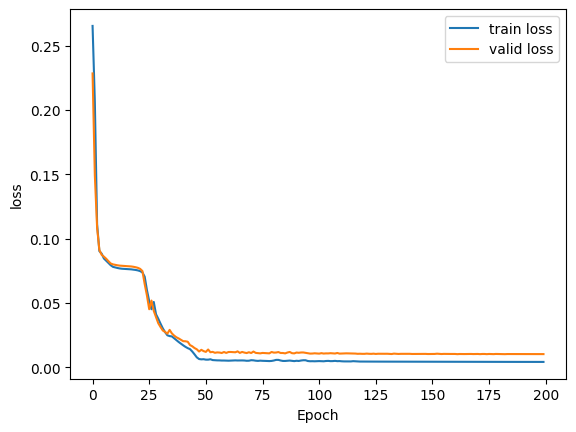

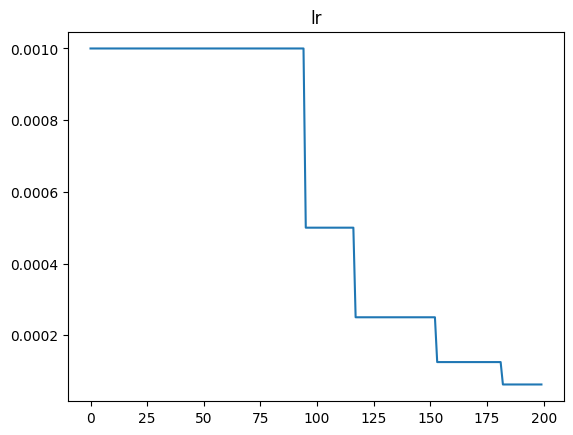

In [27]:
# 저장한 model과 history 불러오기
lstm_ae_20hp = load_model('./모델 저장/20hp.h5')
history = history=np.load('./20hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [28]:
# 역치 계산
pred_train_20hp = lstm_ae_20hp.predict(train_slice_20hp)
train_mse_20hp = np.mean(np.square(flatten(train_slice_20hp) - flatten(pred_train_20hp)), axis =1 )
threshold_20hp = np.max(train_mse_20hp)

# 계산한 역치로 이상 판단
pred_test_20hp = lstm_ae_20hp.predict(test_slice_20hp)
test_mse_20hp = np.mean(np.square(flatten(test_slice_20hp) - flatten(pred_test_20hp)), axis =1 )
anom_20hp = test_mse_20hp > threshold_20hp

# pred 데이터 생성
pred_20hp = test_data_20hp.copy()
pred_20hp['y'] = anom_20hp

# 개수 확인
print(np.sum(anom_20hp))

35/35 [==============================] - 0s 7ms/step
0


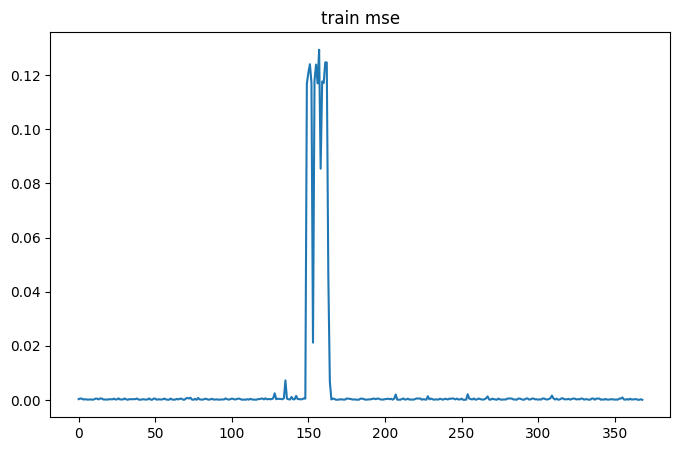

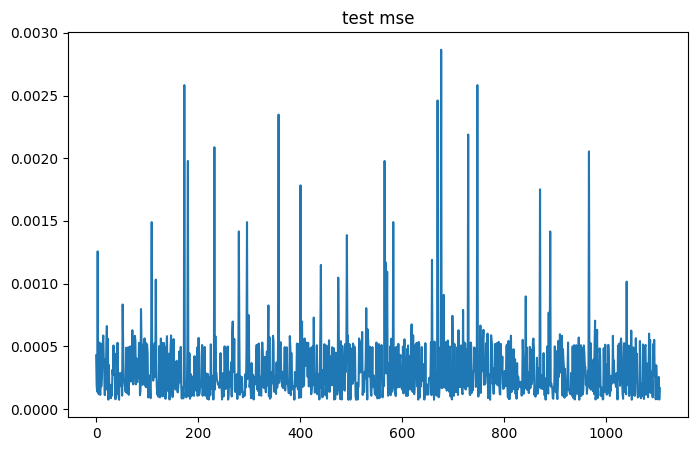

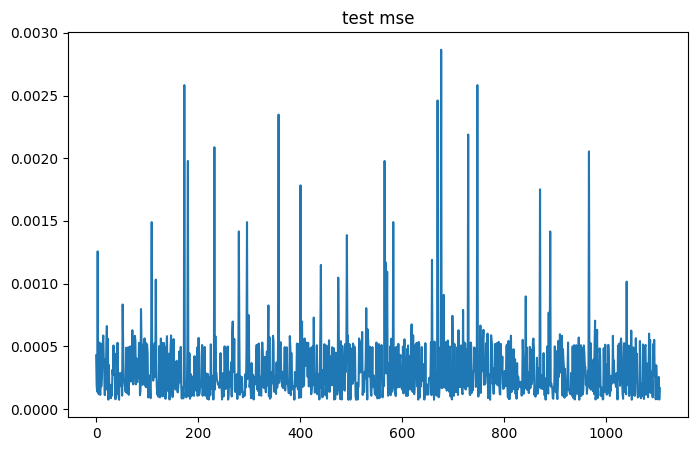

In [29]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_20hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp[~anom_20hp]);
plt.title('test mse');

## 두 번째 모델

In [ ]:
## test mse가 test mse의 평균 + 1 표준편차보다 작은 데이터들 학습에 사용


train_cut_20hp = train_data_20hp[train_mse_20hp < np.max(test_mse_20hp)].copy()
for_new_train_20hp = test_data_20hp[test_mse_20hp < (np.mean(test_mse_20hp) + np.std(test_mse_20hp))].copy()
new_train_20hp = pd.concat([train_cut_20hp, for_new_train_20hp], ignore_index = True)

In [ ]:
# new_train_20hp.to_csv('/content/drive/MyDrive/번천/모델 9/new_train/new_train_20hp.csv')

new_train_20hp = pd.read_csv('/content/drive/MyDrive/번천/모델 9/new_train/new_train_20hp.csv', index_col = 0)


In [ ]:
## 모델 학습을 위해 데이터 준비

scaler_20hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_20hp = pd.concat([test_data_20hp, train_data_20hp], ignore_index = True)
scaler_20hp.fit(full_data_20hp.drop(['type'], axis=1))
train_scale_20hp = scaler_20hp.transform(new_train_20hp.drop(['type'], axis=1))
test_scale_20hp = scaler_20hp.transform(test_data_20hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_20hp = slicing(test_scale_20hp,1).reshape(-1, 7 ,1)
train_slice_20hp = slicing(train_scale_20hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_20hp, test_size=0.1, random_state=seed)

In [ ]:
## 모델 학습

lstm_ae_20hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_20hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장2/20hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_20hp.fit(X_train, X_train,
                           epochs=300, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./history2/20hp_history.npy',history.history)

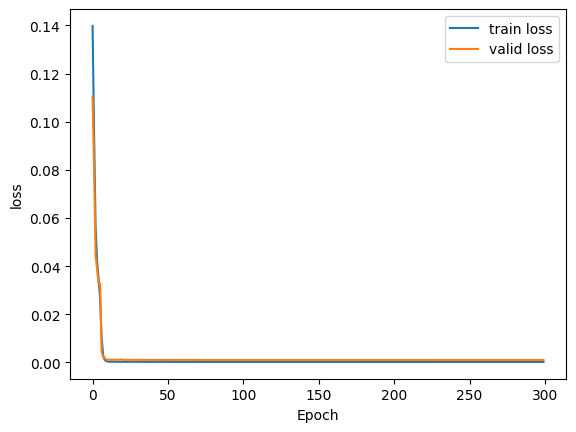

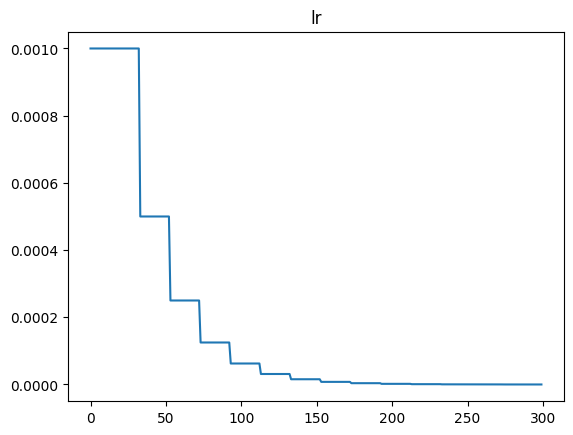

In [ ]:
# 저장한 model과 history 불러오기
lstm_ae_20hp = load_model('./모델 저장2/20hp.h5')
history = history=np.load('./history2/20hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [ ]:
# 역치 계산
pred_train_20hp = lstm_ae_20hp.predict(train_slice_20hp)
train_mse_20hp = np.mean(np.square(flatten(train_slice_20hp) - flatten(pred_train_20hp)), axis =1 )
threshold_20hp = np.max(train_mse_20hp)

# 계산한 역치로 이상 판단
pred_test_20hp = lstm_ae_20hp.predict(test_slice_20hp)
test_mse_20hp = np.mean(np.square(flatten(test_slice_20hp) - flatten(pred_test_20hp)), axis =1 )
anom_20hp = test_mse_20hp > threshold_20hp

# pred 데이터 생성
pred_20hp = test_data_20hp.copy()
pred_20hp['y'] = anom_20hp

# 개수 확인
print(np.sum(anom_20hp))

35/35 [==============================] - 0s 6ms/step
0


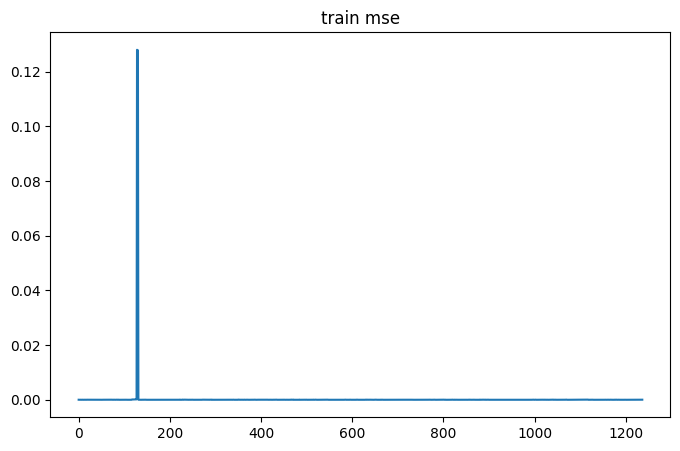

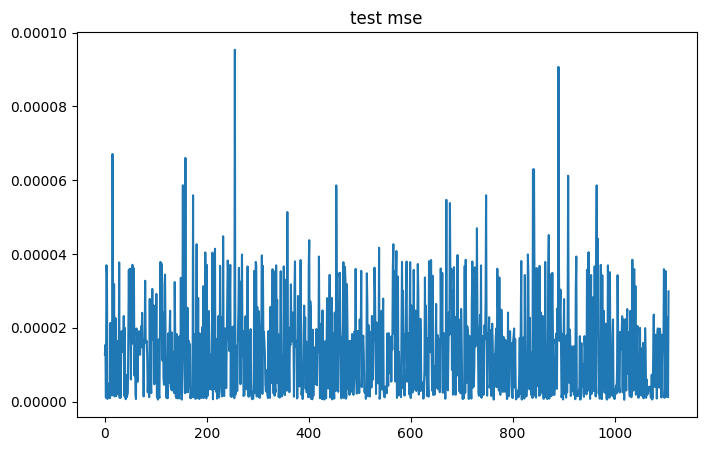

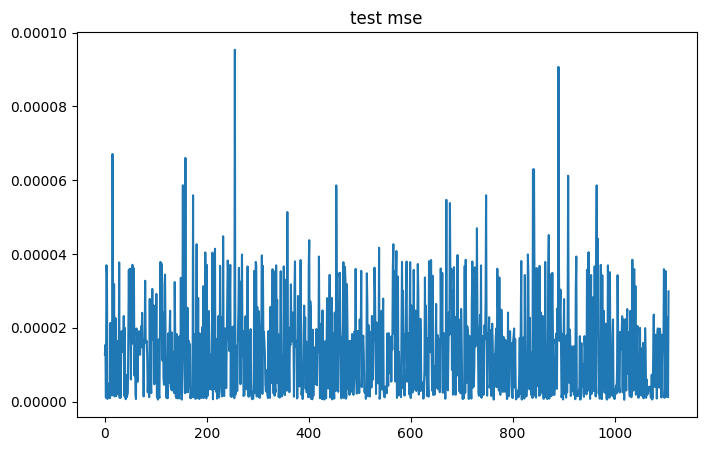

In [ ]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_20hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp[~anom_20hp]);
plt.title('test mse');

## 세 번째 모델

In [ ]:
## test mse가 train mse의 평균 + 1 표준편차보다 작은 데이터들 학습에 사용


train_cut2_20hp = train_cut_20hp[train_mse_20hp < np.max(test_mse_20hp)].copy()
train_cut2_20hp
# for_new_train_20hp = test_data_20hp[test_mse_20hp < (np.mean(train_mse_20hp) + np.std(train_mse_20hp))].copy()
# new_train_20hp = pd.concat([train_data_20hp, for_new_train_20hp], ignore_index = True) 

,air_inflow,motor_current,motor_rpm,motor_temp,motor_vibe,out_pressure,air_end_temp,type
432,1.73,25.60,2973.0,71.03,3.45,0.7,55.16,1
433,1.31,19.32,2244.0,62.93,3.05,0.7,46.05,1
434,1.33,19.69,2287.0,63.41,3.07,0.7,46.59,1
435,1.87,27.56,3200.0,73.56,3.58,0.7,58.00,1
436,1.68,24.78,2878.0,69.98,3.40,0.7,53.98,1
...,...,...,...,...,...,...,...,...
796,0.72,10.56,1226.0,51.62,2.48,0.7,33.33,1
797,0.86,12.68,1473.0,54.37,2.62,0.7,36.41,1
798,0.83,12.31,1430.0,53.89,2.59,0.7,35.88,1
799,1.77,26.07,3028.0,71.64,3.48,0.7,55.85,1


In [ ]:
## 모델 학습을 위해 데이터 준비

scaler_20hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_20hp = pd.concat([test_data_20hp, train_data_20hp], ignore_index = True)
scaler_20hp.fit(full_data_20hp.drop(['type'], axis=1))
train_scale_20hp = scaler_20hp.transform(train_cut2_20hp.drop(['type'], axis=1))
test_scale_20hp = scaler_20hp.transform(test_data_20hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_20hp = slicing(test_scale_20hp,1).reshape(-1, 7 ,1)
train_slice_20hp = slicing(train_scale_20hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_20hp, test_size=0.1, random_state=seed)

In [ ]:
## 모델 학습

lstm_ae_20hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_20hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장3/20hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_20hp.fit(X_train, X_train,
                           epochs=200, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./history3/20hp_history.npy',history.history)

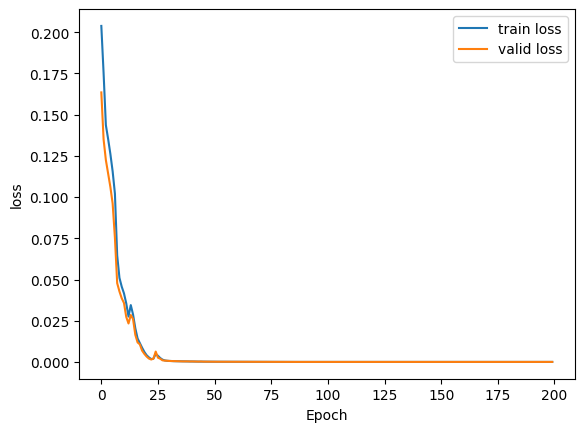

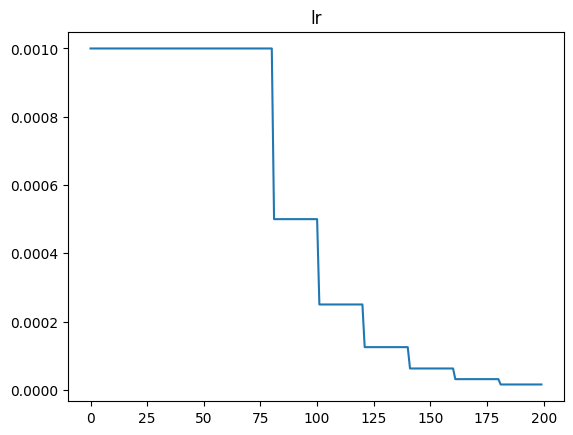

In [ ]:
# 저장한 model과 history 불러오기
lstm_ae_20hp = load_model('./모델 저장3/20hp.h5')
history = history=np.load('./history3/20hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [ ]:
# 역치 계산
pred_train_20hp = lstm_ae_20hp.predict(train_slice_20hp)
train_mse_20hp = np.mean(np.square(flatten(train_slice_20hp) - flatten(pred_train_20hp)), axis =1 )
threshold_20hp = np.max(train_mse_20hp)

# 계산한 역치로 이상 판단
pred_test_20hp = lstm_ae_20hp.predict(test_slice_20hp)
test_mse_20hp = np.mean(np.square(flatten(test_slice_20hp) - flatten(pred_test_20hp)), axis =1 )
anom_20hp = test_mse_20hp > threshold_20hp

# pred 데이터 생성
pred_20hp = test_data_20hp.copy()
pred_20hp['y'] = anom_20hp

# 개수 확인
print(np.sum(anom_20hp))

35/35 [==============================] - 0s 6ms/step
4


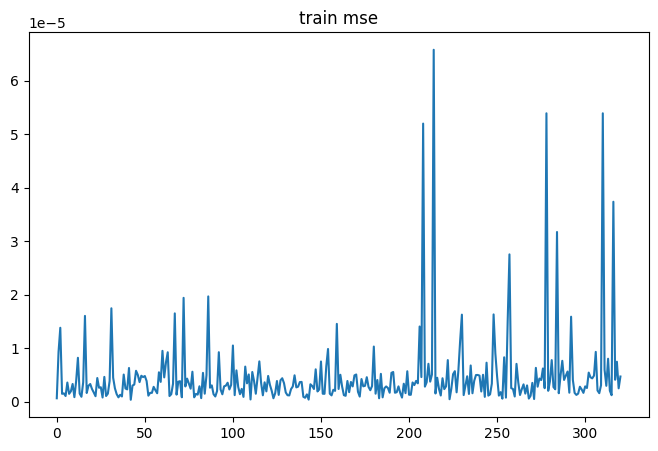

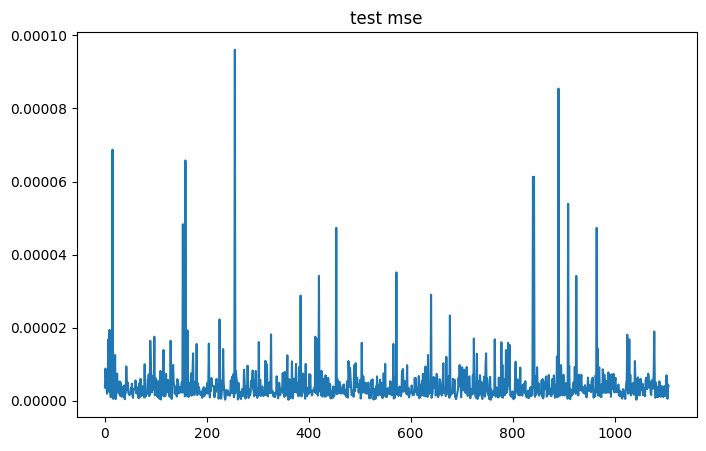

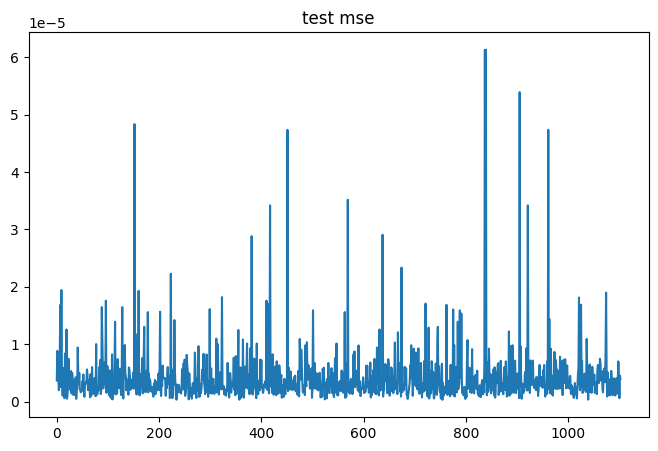

In [ ]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_20hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp[~anom_20hp]);
plt.title('test mse');

# hp10


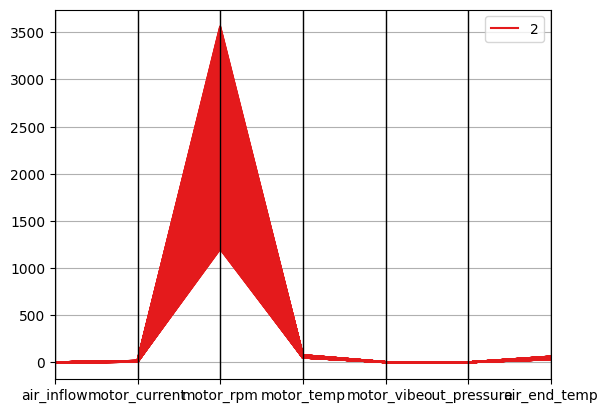

In [ ]:
parallel(train_data, hp10)

## 첫 번째 모델

In [30]:
## 모델 학습을 위해 데이터 준비

scaler_10hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화


full_data = pd.concat([test_data, train_data], ignore_index = True)
scaler_10hp.fit(full_data.drop(['type'], axis=1))
test_scale_10hp = scaler_10hp.transform(test_data_10hp.drop(['type'], axis=1))
train_scale_10hp = scaler_10hp.transform(train_data_10hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_10hp = slicing(test_scale_10hp,1).reshape(-1, 7 ,1)
train_slice_10hp = slicing(train_scale_10hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_10hp, test_size=0.1, random_state=seed)

In [31]:
## 모델 학습

lstm_ae_10hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_10hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장/10hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_10hp.fit(X_train, X_train,
                           epochs=300, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./10hp_history.npy',history.history)

Epoch 1/300
10/11 [==========================>...] - ETA: 0s - loss: 0.2435
Epoch 1: val_loss improved from inf to 0.20618, saving model to ./모델 저장/10hp.h5
11/11 [==============================] - 8s 103ms/step - loss: 0.2421 - val_loss: 0.2062 - lr: 0.0010
Epoch 2/300
10/11 [==========================>...] - ETA: 0s - loss: 0.1932
Epoch 2: val_loss improved from 0.20618 to 0.13860, saving model to ./모델 저장/10hp.h5
11/11 [==============================] - 0s 33ms/step - loss: 0.1932 - val_loss: 0.1386 - lr: 0.0010
Epoch 3/300
11/11 [==============================] - ETA: 0s - loss: 0.1133
Epoch 3: val_loss improved from 0.13860 to 0.10480, saving model to ./모델 저장/10hp.h5
11/11 [==============================] - 1s 51ms/step - loss: 0.1133 - val_loss: 0.1048 - lr: 0.0010
Epoch 4/300
11/11 [==============================] - ETA: 0s - loss: 0.0957
Epoch 4: val_loss improved from 0.10480 to 0.09613, saving model to ./모델 저장/10hp.h5
11/11 [=============================

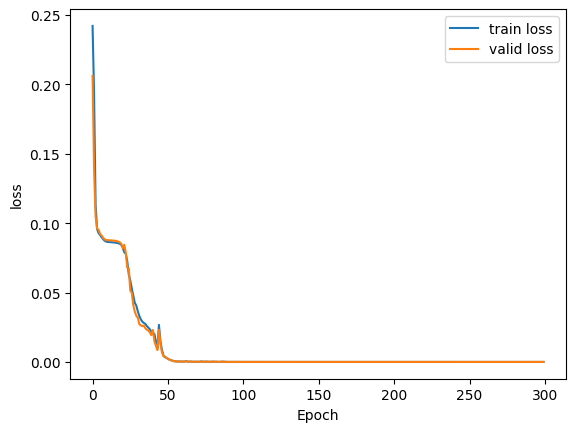

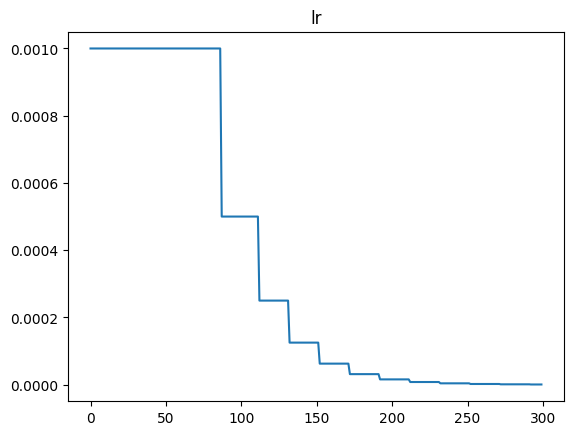

In [32]:
# 저장한 model과 history 불러오기
lstm_ae_10hp = load_model('./모델 저장/10hp.h5')
history = history=np.load('./10hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [33]:
# 역치 계산
pred_train_10hp = lstm_ae_10hp.predict(train_slice_10hp)
train_mse_10hp = np.mean(np.square(flatten(train_slice_10hp) - flatten(pred_train_10hp)), axis =1 )
threshold_10hp = np.max(train_mse_10hp)

# 계산한 역치로 이상 판단
pred_test_10hp = lstm_ae_10hp.predict(test_slice_10hp)
test_mse_10hp = np.mean(np.square(flatten(test_slice_10hp) - flatten(pred_test_10hp)), axis =1 )
anom_10hp = test_mse_10hp > threshold_10hp

# pred 데이터 생성
pred_10hp = test_data_10hp.copy()
pred_10hp['y'] = anom_10hp

# 개수 확인
print(np.sum(anom_10hp))

35/35 [==============================] - 0s 7ms/step
24


In [34]:
# anom_10hp = test_mse_10hp > np.mean(train_mse_10hp) + 100*np.std(train_mse_10hp)

# # pred 데이터 생성
# pred_10hp = test_data_10hp.copy()
# pred_10hp['y'] = anom_10hp

# # 개수 확인
# print(np.sum(anom_10hp))

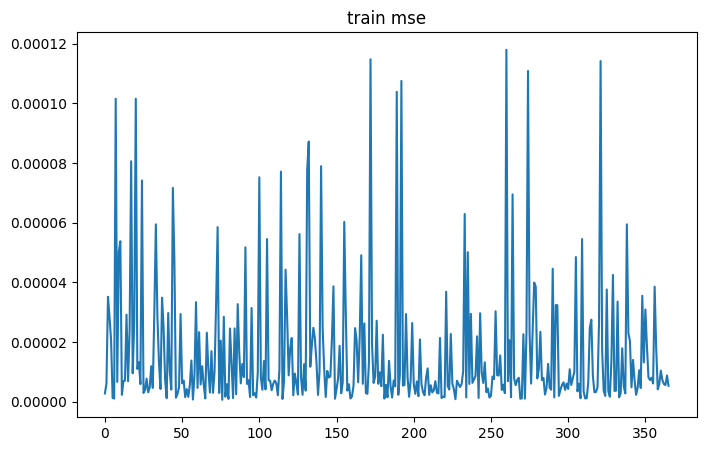

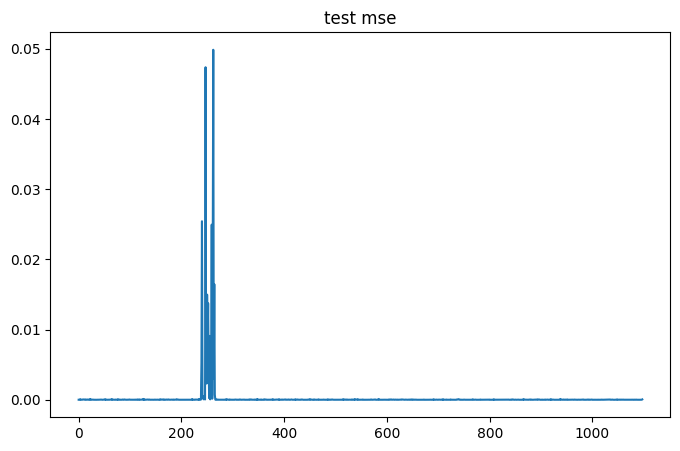

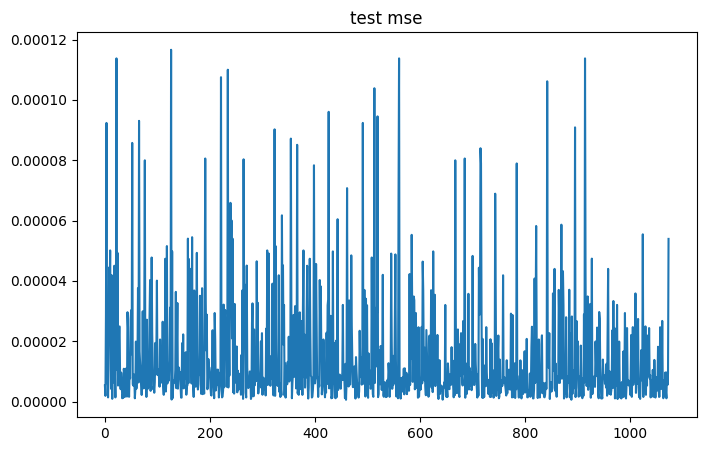

In [35]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_10hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_10hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_10hp[~anom_10hp]);
plt.title('test mse');

## 두 번째 모델

In [ ]:
## test mse가 train mse의 평균 + 1 표준편차보다 작은 데이터들 학습에 사용

for_new_train_10hp = test_data_10hp[test_mse_10hp < (np.mean(train_mse_10hp) + np.std(train_mse_10hp))].copy()
new_train_10hp = pd.concat([train_data_10hp, for_new_train_10hp], ignore_index = True) 

In [ ]:
new_train_10hp.to_csv('/content/drive/MyDrive/번천/모델 9/new_train/new_train_10hp.csv')

In [ ]:
## 모델 학습을 위해 데이터 준비

scaler_10hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_10hp = pd.concat([test_data_10hp, train_data_10hp], ignore_index = True)
scaler_10hp.fit(full_data_10hp.drop(['type'], axis=1))
train_scale_10hp = scaler_10hp.transform(new_train_10hp.drop(['type'], axis=1))
test_scale_10hp = scaler_10hp.transform(test_data_10hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_10hp = slicing(test_scale_10hp,1).reshape(-1, 7 ,1)
train_slice_10hp = slicing(train_scale_10hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_10hp, test_size=0.1, random_state=seed)

In [ ]:
## 모델 학습

lstm_ae_10hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_10hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장2/10hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_10hp.fit(X_train, X_train,
                           epochs=300, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./history2/10hp_history.npy',history.history)

Epoch 1/300
40/40 [==============================] - ETA: 0s - loss: 0.1919
Epoch 1: val_loss improved from inf to 0.12421, saving model to ./모델 저장2/10hp.h5
40/40 [==============================] - 10s 49ms/step - loss: 0.1919 - val_loss: 0.1242 - lr: 0.0010
Epoch 2/300
39/40 [============================>.] - ETA: 0s - loss: 0.1022
Epoch 2: val_loss improved from 0.12421 to 0.04909, saving model to ./모델 저장2/10hp.h5
40/40 [==============================] - 1s 28ms/step - loss: 0.1020 - val_loss: 0.0491 - lr: 0.0010
Epoch 3/300
39/40 [============================>.] - ETA: 0s - loss: 0.0406
Epoch 3: val_loss improved from 0.04909 to 0.03288, saving model to ./모델 저장2/10hp.h5
40/40 [==============================] - 1s 27ms/step - loss: 0.0406 - val_loss: 0.0329 - lr: 0.0010
Epoch 4/300
38/40 [===========================>..] - ETA: 0s - loss: 0.0348
Epoch 4: val_loss improved from 0.03288 to 0.03048, saving model to ./모델 저장2/10hp.h5
40/40 [=========================

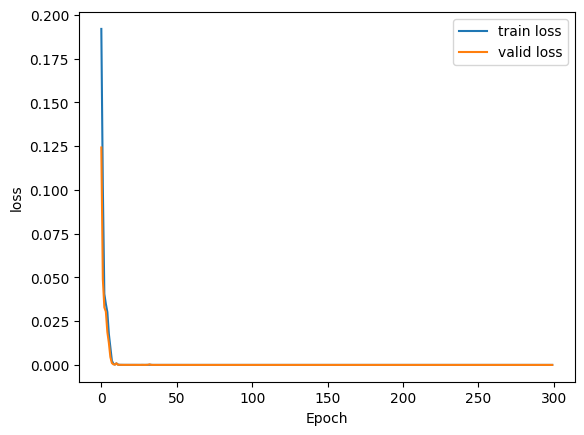

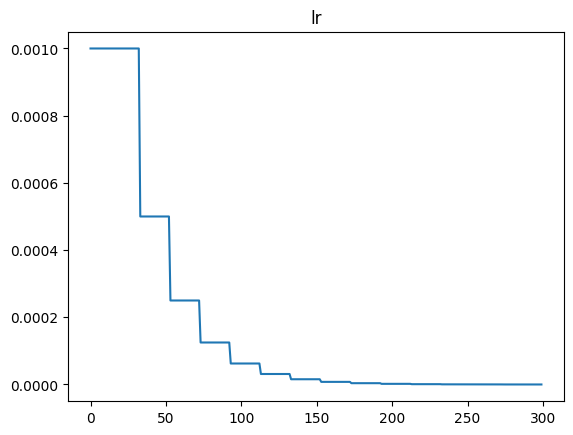

In [ ]:
# 저장한 model과 history 불러오기
lstm_ae_10hp = load_model('./모델 저장2/10hp.h5')
history = history=np.load('./history2/10hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [ ]:
# 역치 계산
pred_train_10hp = lstm_ae_10hp.predict(train_slice_10hp)
train_mse_10hp = np.mean(np.square(flatten(train_slice_10hp) - flatten(pred_train_10hp)), axis =1 )
threshold_10hp = np.max(train_mse_10hp)

# 계산한 역치로 이상 판단
pred_test_10hp = lstm_ae_10hp.predict(test_slice_10hp)
test_mse_10hp = np.mean(np.square(flatten(test_slice_10hp) - flatten(pred_test_10hp)), axis =1 )
anom_10hp = test_mse_10hp > threshold_10hp

# pred 데이터 생성
pred_10hp = test_data_10hp.copy()
pred_10hp['y'] = anom_10hp

# 개수 확인
print(np.sum(anom_10hp))

35/35 [==============================] - 0s 9ms/step
27


In [ ]:
anom_10hp = test_mse_10hp > np.mean(train_mse_10hp) + 10*np.std(train_mse_10hp)

# pred 데이터 생성
pred_10hp = test_data_10hp.copy()
pred_10hp['y'] = anom_10hp

# 개수 확인
print(np.sum(anom_10hp))

27


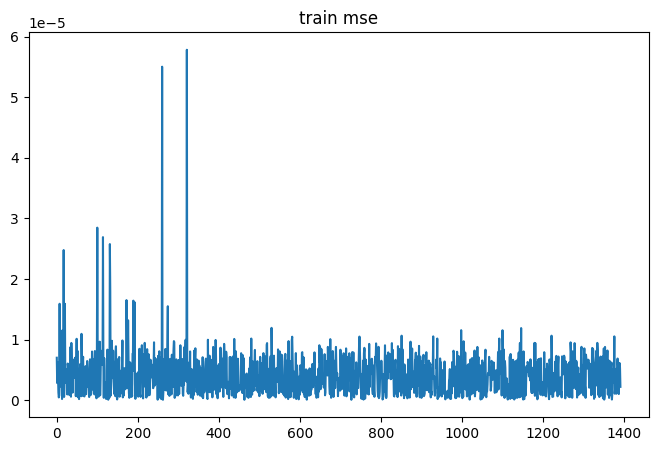

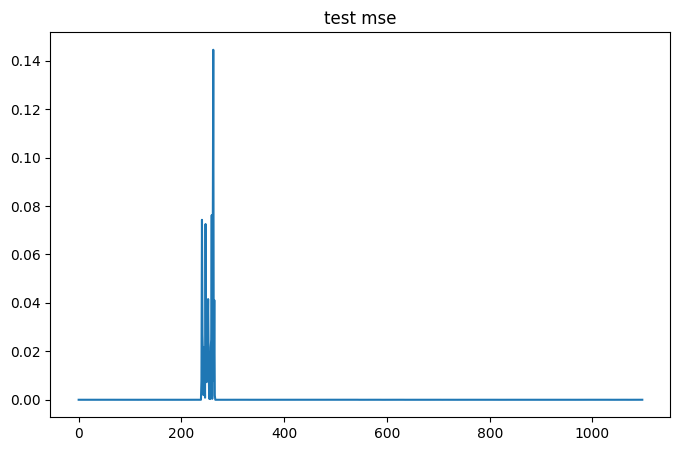

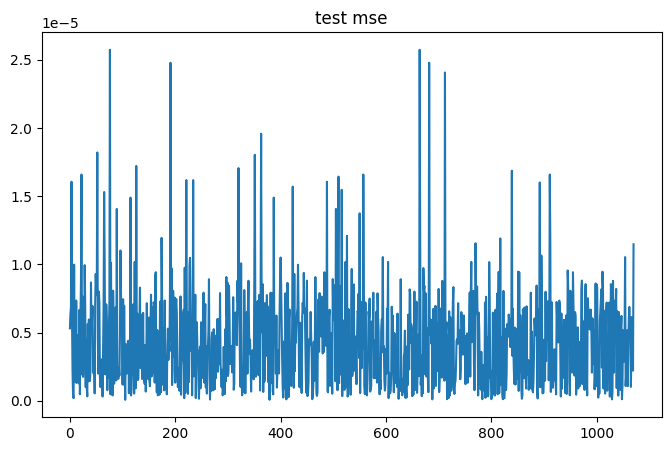

In [ ]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_10hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_10hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_10hp[~anom_10hp]);
plt.title('test mse');

# hp50

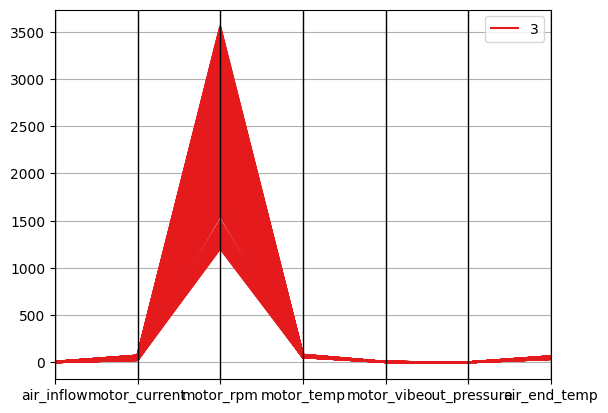

In [ ]:
parallel(train_data, hp50)

## 첫 번째 모델

In [36]:
## 모델 학습을 위해 데이터 준비

scaler_50hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화


full_data = pd.concat([test_data, train_data], ignore_index = True)
scaler_50hp.fit(full_data.drop(['type'], axis=1))
test_scale_50hp = scaler_50hp.transform(test_data_50hp.drop(['type'], axis=1))
train_scale_50hp = scaler_50hp.transform(train_data_50hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_50hp = slicing(test_scale_50hp,1).reshape(-1, 7 ,1)
train_slice_50hp = slicing(train_scale_50hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_50hp, test_size=0.1, random_state=seed)

In [37]:
## 모델 학습

lstm_ae_50hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_50hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장/50hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_50hp.fit(X_train, X_train,
                           epochs=300, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./50hp_history.npy',history.history)

Epoch 1/300
9/9 [==============================] - ETA: 0s - loss: 0.4067
Epoch 1: val_loss improved from inf to 0.44737, saving model to ./모델 저장/50hp.h5
9/9 [==============================] - 9s 143ms/step - loss: 0.4067 - val_loss: 0.4474 - lr: 0.0010
Epoch 2/300
9/9 [==============================] - ETA: 0s - loss: 0.3310
Epoch 2: val_loss improved from 0.44737 to 0.32118, saving model to ./모델 저장/50hp.h5
9/9 [==============================] - 0s 38ms/step - loss: 0.3310 - val_loss: 0.3212 - lr: 0.0010
Epoch 3/300
7/9 [======================>.......] - ETA: 0s - loss: 0.2078
Epoch 3: val_loss improved from 0.32118 to 0.19589, saving model to ./모델 저장/50hp.h5
9/9 [==============================] - 0s 39ms/step - loss: 0.1972 - val_loss: 0.1959 - lr: 0.0010
Epoch 4/300
8/9 [=========================>....] - ETA: 0s - loss: 0.1572
Epoch 4: val_loss improved from 0.19589 to 0.17512, saving model to ./모델 저장/50hp.h5
9/9 [==============================] - 0s 40ms/ste

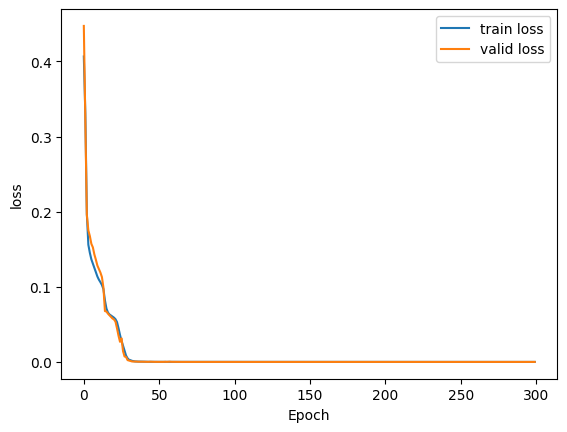

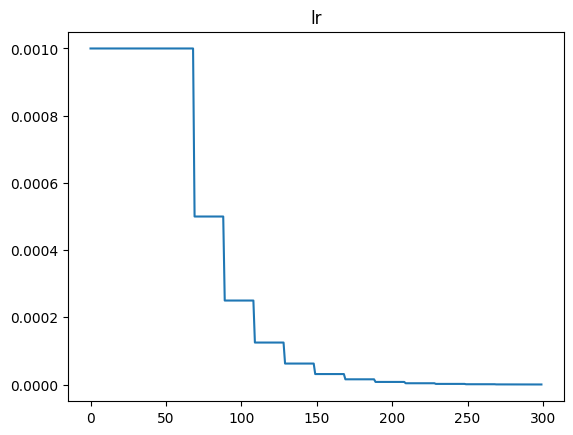

In [38]:
# 저장한 model과 history 불러오기
lstm_ae_50hp = load_model('./모델 저장/50hp.h5')
history = history=np.load('./50hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [43]:
# 역치 계산
pred_train_50hp = lstm_ae_50hp.predict(train_slice_50hp)
train_mse_50hp = np.mean(np.square(flatten(train_slice_50hp) - flatten(pred_train_50hp)), axis =1 )
threshold_50hp = np.max(train_mse_50hp)

# 계산한 역치로 이상 판단
pred_test_50hp = lstm_ae_50hp.predict(test_slice_50hp)
test_mse_50hp = np.mean(np.square(flatten(test_slice_50hp) - flatten(pred_test_50hp)), axis =1 )
anom_50hp = test_mse_50hp > threshold_50hp

# pred 데이터 생성
pred_50hp = test_data_50hp.copy()
pred_50hp['y'] = anom_50hp

# 개수 확인
print(np.sum(anom_50hp))

29/29 [==============================] - 0s 7ms/step
28


In [40]:
anom_50hp = test_mse_50hp > np.mean(train_mse_50hp) + 100*np.std(train_mse_50hp)

# pred 데이터 생성
pred_50hp = test_data_50hp.copy()
pred_50hp['y'] = anom_50hp

# 개수 확인
print(np.sum(anom_50hp))

0


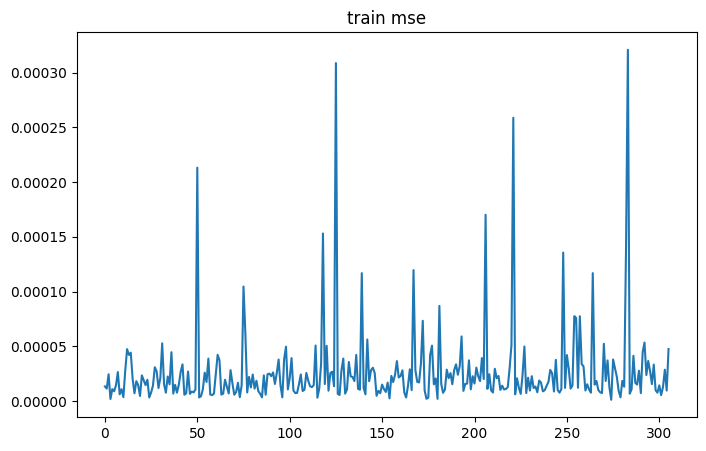

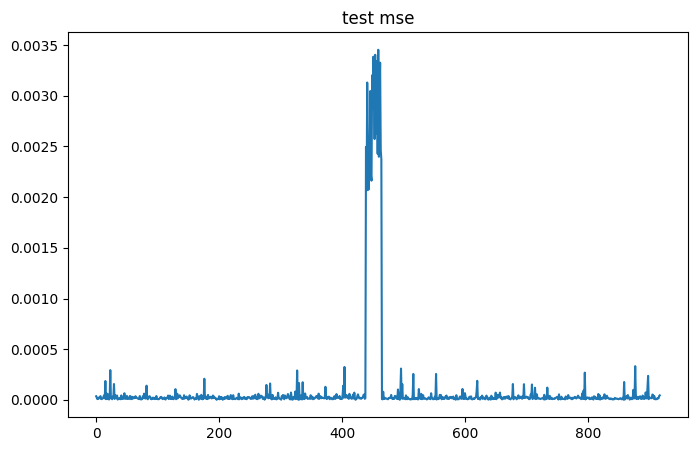

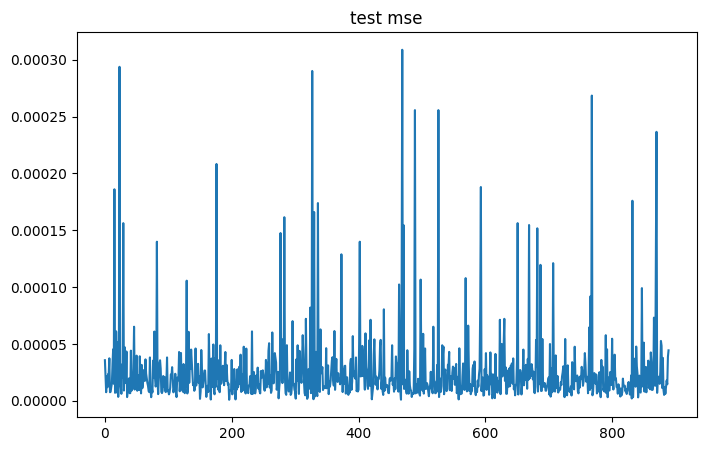

In [45]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_50hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_50hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_50hp[~anom_50hp]);
plt.title('test mse');

## 두 번째 모델

In [ ]:
## test mse가 train mse의 평균 + 1 표준편차보다 작은 데이터들 학습에 사용

for_new_train_50hp = test_data_50hp[test_mse_50hp < (np.mean(train_mse_50hp) + np.std(train_mse_50hp))].copy()
new_train_50hp = pd.concat([train_data_50hp, for_new_train_50hp], ignore_index = True) 

In [ ]:
new_train_50hp.to_csv('/content/drive/MyDrive/번천/모델 9/new_train/new_train_50hp.csv')

In [ ]:
## 모델 학습을 위해 데이터 준비

scaler_50hp = MinMaxScaler()

# 설비 라벨 제외하여 full data로 정규화
full_data_50hp = pd.concat([test_data_50hp, train_data_50hp], ignore_index = True)
scaler_50hp.fit(full_data_50hp.drop(['type'], axis=1))
test_scale_50hp = scaler_50hp.transform(test_data_50hp.drop(['type'], axis=1))
train_scale_50hp = scaler_50hp.transform(new_train_50hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_50hp = slicing(test_scale_50hp,1).reshape(-1, 7 ,1)
train_slice_50hp = slicing(train_scale_50hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_50hp, test_size=0.1, random_state=seed)

In [ ]:
## 모델 학습

lstm_ae_50hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_50hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장2/50hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_50hp.fit(X_train, X_train,
                           epochs=300, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./history2/50hp_history.npy',history.history)

Epoch 1/300
31/32 [============================>.] - ETA: 0s - loss: 0.1998
Epoch 1: val_loss improved from inf to 0.15248, saving model to ./모델 저장2/50hp.h5
32/32 [==============================] - 8s 73ms/step - loss: 0.1985 - val_loss: 0.1525 - lr: 0.0010
Epoch 2/300
30/32 [===========================>..] - ETA: 0s - loss: 0.1267
Epoch 2: val_loss improved from 0.15248 to 0.11514, saving model to ./모델 저장2/50hp.h5
32/32 [==============================] - 1s 31ms/step - loss: 0.1256 - val_loss: 0.1151 - lr: 0.0010
Epoch 3/300
30/32 [===========================>..] - ETA: 0s - loss: 0.0742
Epoch 3: val_loss improved from 0.11514 to 0.04381, saving model to ./모델 저장2/50hp.h5
32/32 [==============================] - 1s 24ms/step - loss: 0.0721 - val_loss: 0.0438 - lr: 0.0010
Epoch 4/300
30/32 [===========================>..] - ETA: 0s - loss: 0.0379
Epoch 4: val_loss improved from 0.04381 to 0.03583, saving model to ./모델 저장2/50hp.h5
32/32 [==========================

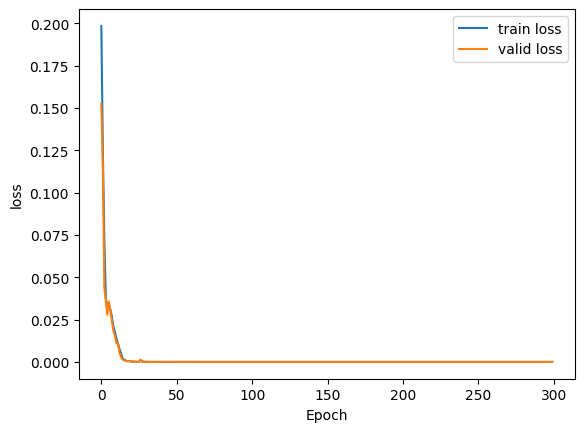

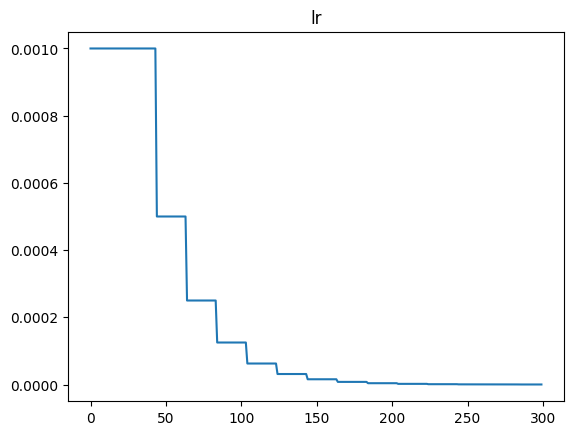

In [ ]:
# 저장한 model과 history 불러오기
lstm_ae_50hp = load_model('./모델 저장2/50hp.h5')
history = history=np.load('./history2/50hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [ ]:
# 역치 계산
pred_train_50hp = lstm_ae_50hp.predict(train_slice_50hp)
train_mse_50hp = np.mean(np.square(flatten(train_slice_50hp) - flatten(pred_train_50hp)), axis =1 )
threshold_50hp = np.max(train_mse_50hp)

# 계산한 역치로 이상 판단
pred_test_50hp = lstm_ae_50hp.predict(test_slice_50hp)
test_mse_50hp = np.mean(np.square(flatten(test_slice_50hp) - flatten(pred_test_50hp)), axis =1 )
anom_50hp = test_mse_50hp > threshold_50hp

# pred 데이터 생성
pred_50hp = test_data_50hp.copy()
pred_50hp['y'] = anom_50hp

# 개수 확인
print(np.sum(anom_50hp))

29/29 [==============================] - 0s 9ms/step
27


In [ ]:
anom_50hp = test_mse_50hp > np.mean(train_mse_50hp) + 10*np.std(train_mse_50hp)

# pred 데이터 생성
pred_50hp = test_data_50hp.copy()
pred_50hp['y'] = anom_50hp

# 개수 확인
print(np.sum(anom_50hp))

34


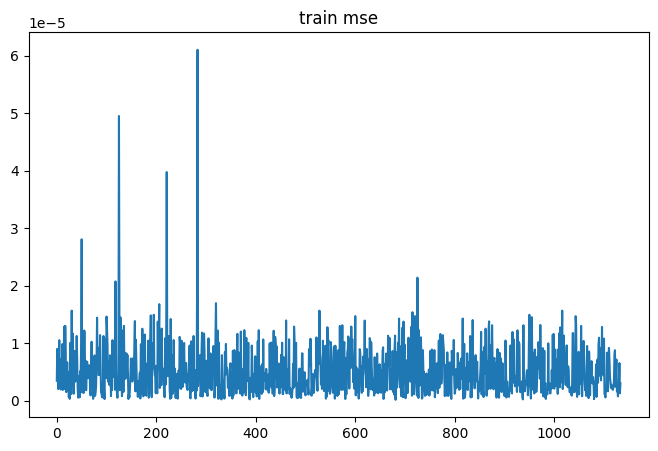

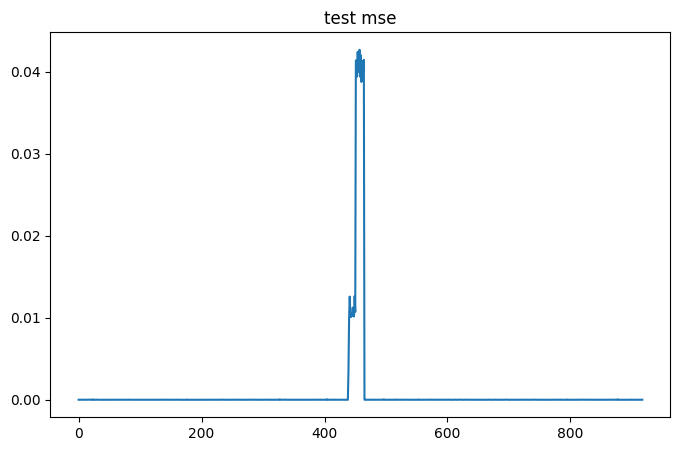

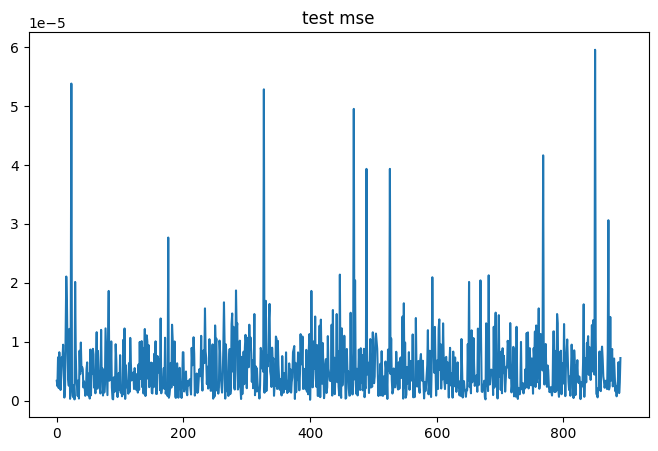

In [ ]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_50hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_50hp);
plt.title('test mse');

# 정상으로 유추한 test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_50hp[~anom_50hp]);
plt.title('test mse');

# pred 합치기

test_data_30hp

test_data_20hp

test_data_10hp

test_data_50hp

In [46]:
answer = pd.concat([pred_30hp['y'], pred_20hp['y'], pred_10hp['y'], pred_50hp['y']]).sort_index()
answer = pd.concat([test_data['type'], answer], axis=1)
answer.rename(columns={'y':'label'}, inplace = True)

In [47]:
answer['label'].sum()

345

In [50]:
print(answer['label'][answer['type'].isin(hp30)].sum())
print(answer['label'][answer['type'].isin(hp20)].sum())
print(answer['label'][answer['type'].isin(hp10)].sum())
print(answer['label'][answer['type'].isin(hp50)].sum())

293
0
24
28


In [49]:
answer.to_csv("/content/drive/MyDrive/번천/answer/answer_model_10_tot.csv")